<a href="https://colab.research.google.com/github/MitaliThorat1316/Twitter-Sentiment-Analysis/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing dependencies**

In [5]:
# utilities
import os
import re
import numpy as np
import pandas as pd

# plotting
#!pip install wordcloud
#!pip install --upgrade wordcloud
#!pip install --upgrade pillow
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')  # optional, provides additional WordNet information

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Load dataset**

In [6]:
df = pd.read_csv(r'/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',
                    encoding='ISO-8859-1',
                    names = ['sentiment','ids','date', 'flag', 'user', 'tweet'])

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dataset Analysis**

In [8]:
df.head()

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   tweet      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
df.sentiment.value_counts()

,count
sentiment,
0,800000
4,800000


In [11]:
df.shape

(1600000, 6)

In [12]:
#find the maximum length
max_len = max([len(sent) for sent in df.tweet])
print('Max length: ', max_len)

Max length:  374


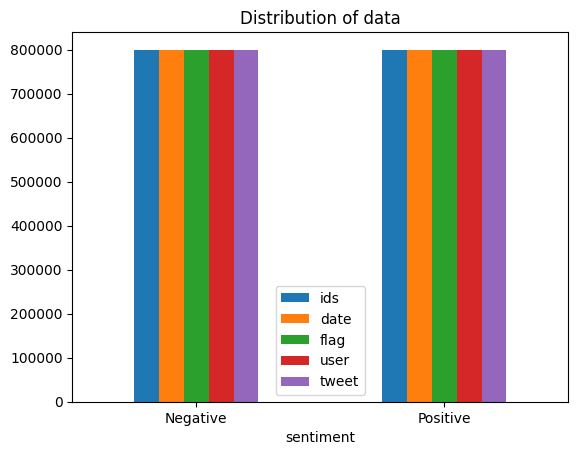

In [13]:
# Plotting the distribution for dataset.
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=True)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
tweet, sentiment = list(df['tweet']), list(df['sentiment'])

<Axes: xlabel='sentiment', ylabel='count'>

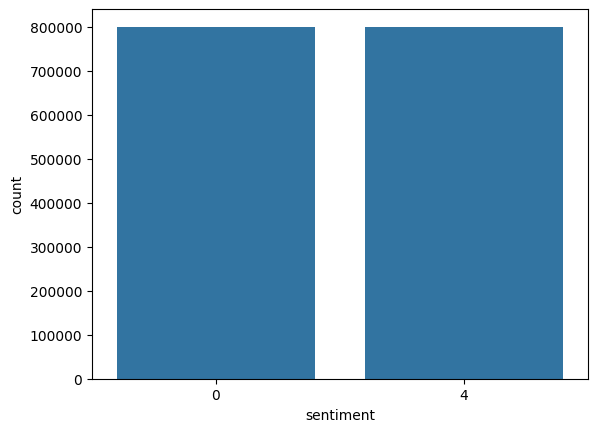

In [14]:
import seaborn as sns
sns.countplot(x='sentiment', data=df)

**Data preprocessing**

In [15]:
data=df[['tweet','sentiment']]

In [16]:
data.loc[:, 'sentiment'] = data['sentiment'].replace(4, 1)

In [17]:
data_pos = data[data['sentiment'] == 1]
data_neg = data[data['sentiment'] == 0]

In [18]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [19]:
dataset = pd.concat([data_pos, data_neg])

In [20]:
dataset.head()

,tweet,sentiment
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1


In [21]:
dataset['tweet']=dataset['tweet'].str.lower()
dataset['tweet'].head()

,tweet
800000,i love @health4uandpets u guys r the best!!
800001,im meeting up with one of my besties tonight! ...
800002,"@darealsunisakim thanks for the twitter add, s..."
800003,being sick can be really cheap when it hurts t...
800004,@lovesbrooklyn2 he has that effect on everyone


In [22]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s',
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [23]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['tweet'] = dataset['tweet'].apply(lambda text: cleaning_stopwords(text))
dataset['tweet'].head()

,tweet
800000,love @health4uandpets u guys r best!!
800001,im meeting one besties tonight! cant wait!! - ...
800002,"@darealsunisakim thanks twitter add, sunisa! g..."
800003,sick really cheap hurts much eat real food plu...
800004,@lovesbrooklyn2 effect everyone


In [24]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['tweet']= dataset['tweet'].apply(lambda x: cleaning_punctuations(x))
dataset['tweet'].head()

,tweet
800000,love health4uandpets u guys r best
800001,im meeting one besties tonight cant wait girl...
800002,darealsunisakim thanks twitter add sunisa got ...
800003,sick really cheap hurts much eat real food plu...
800004,lovesbrooklyn2 effect everyone


In [25]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['tweet'] = dataset['tweet'].apply(lambda x: cleaning_repeating_char(x))
dataset['tweet'].head()

,tweet
800000,love health4uandpets u guys r best
800001,im meeting one besties tonight cant wait girl...
800002,darealsunisakim thanks twitter add sunisa got ...
800003,sick really cheap hurts much eat real food plu...
800004,lovesbrooklyn2 effect everyone


In [26]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['tweet'] = dataset['tweet'].apply(lambda x: cleaning_URLs(x))
dataset['tweet'].head()

,tweet
800000,love health4uandpets u guys r best
800001,im meeting one besties tonight cant wait girl...
800002,darealsunisakim thanks twitter add sunisa got ...
800003,sick really cheap hurts much eat real food plu...
800004,lovesbrooklyn2 effect everyone


In [27]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['tweet'] = dataset['tweet'].apply(lambda x: cleaning_numbers(x))
dataset['tweet'].head()

,tweet
800000,love healthuandpets u guys r best
800001,im meeting one besties tonight cant wait girl...
800002,darealsunisakim thanks twitter add sunisa got ...
800003,sick really cheap hurts much eat real food plu...
800004,lovesbrooklyn effect everyone


In [28]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['tweet'] = dataset['tweet'].astype(str)
dataset['tweet'] = dataset['tweet'].apply(tokenizer.tokenize)
dataset['tweet'].head()

,tweet
800000,"[love, healthuandpets, u, guys, r, best]"
800001,"[im, meeting, one, besties, tonight, cant, wai..."
800002,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,"[sick, really, cheap, hurts, much, eat, real, ..."
800004,"[lovesbrooklyn, effect, everyone]"


In [29]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['tweet']= dataset['tweet'].apply(lambda x: stemming_on_text(x))
dataset['tweet'].head()

,tweet
800000,"[love, healthuandpets, u, guys, r, best]"
800001,"[im, meeting, one, besties, tonight, cant, wai..."
800002,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,"[sick, really, cheap, hurts, much, eat, real, ..."
800004,"[lovesbrooklyn, effect, everyone]"


In [30]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text
dataset['tweet'] = dataset['tweet'].apply(lambda x: lemmatizer_on_text(x))
dataset['tweet'].head()

,tweet
800000,"[love, healthuandpets, u, guy, r, best]"
800001,"[im, meeting, one, besties, tonight, cant, wai..."
800002,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,"[sick, really, cheap, hurt, much, eat, real, f..."
800004,"[lovesbrooklyn, effect, everyone]"


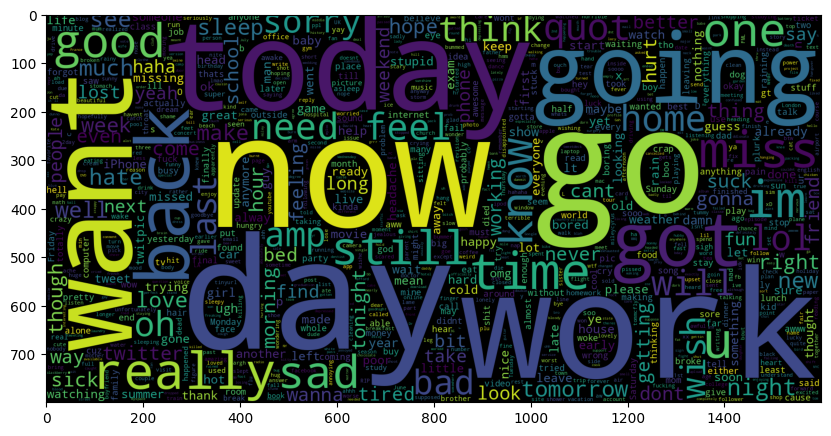

In [31]:
data_neg_ = data['tweet'][:800000]
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg_))
plt.imshow(wc)

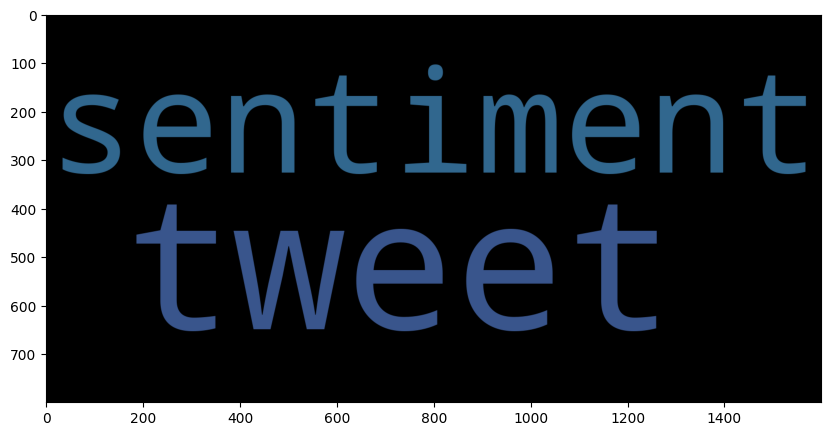

In [49]:
data_pos_ = data['tweet'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (10,10))
plt.imshow(wc)

**Splitting data into training and testing**

In [33]:
X=dataset.tweet
y=dataset.sentiment

In [34]:
X.head(), y.head()

(800000              [love, healthuandpets, u, guy, r, best]
 800001    [im, meeting, one, besties, tonight, cant, wai...
 800002    [darealsunisakim, thanks, twitter, add, sunisa...
 800003    [sick, really, cheap, hurt, much, eat, real, f...
 800004                    [lovesbrooklyn, effect, everyone]
 Name: tweet, dtype: object,
 800000    1
 800001    1
 800002    1
 800003    1
 800004    1
 Name: sentiment, dtype: int64)

In [35]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify=y, random_state =42)

**Transforming the Dataset Using TF-IDF Vectorizer**

In [36]:
X_train_list = X_train.tolist()
# Ensure all elements are strings
X_train_list = [str(x) for x in X_train_list]


In [37]:
X_test_list = X_test.tolist()
# Ensure all elements are strings
X_test_list = [str(x) for x in X_test_list]

In [38]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train_list)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  211588


In [39]:
X_train_new = vectoriser.transform(X_train_list)
X_test_new  = vectoriser.transform(X_test_list)

**Function for Model Evaluation**

In [40]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test_new)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Model Building**

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      4000
           1       0.77      0.74      0.75      4000

    accuracy                           0.76      8000
   macro avg       0.76      0.76      0.76      8000
weighted avg       0.76      0.76      0.76      8000



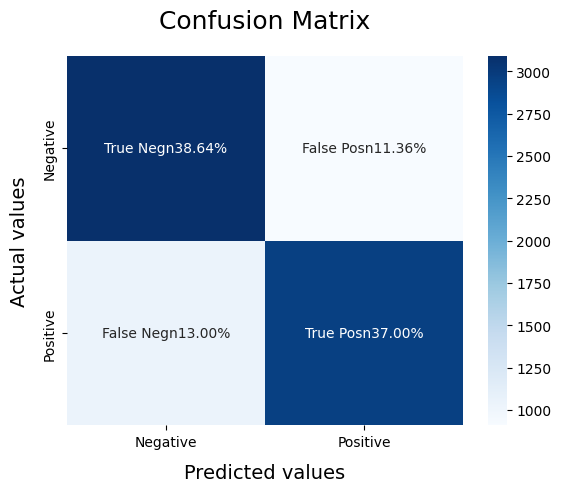

In [41]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_new, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test_new)

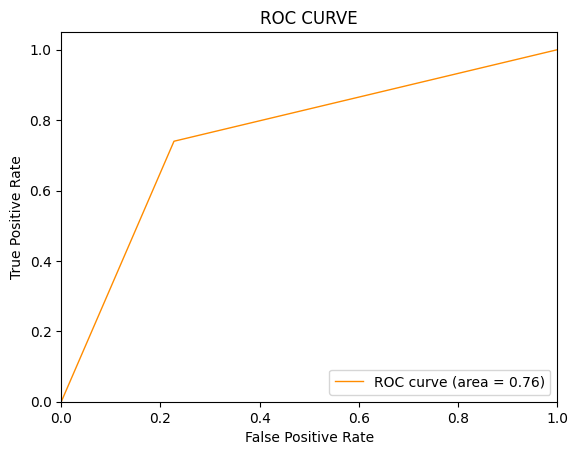

In [42]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.75      0.78      0.77      4000
           1       0.77      0.75      0.76      4000

    accuracy                           0.76      8000
   macro avg       0.76      0.76      0.76      8000
weighted avg       0.76      0.76      0.76      8000



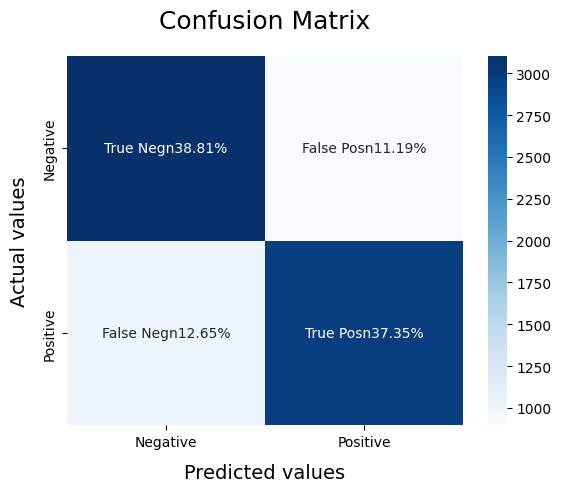

In [43]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_new, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test_new)

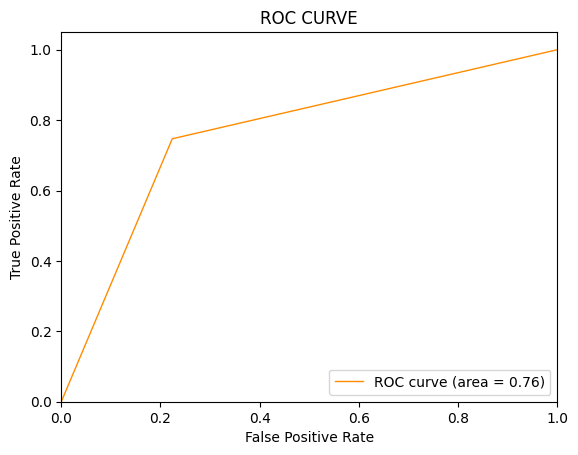

In [44]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      4000
           1       0.78      0.76      0.77      4000

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



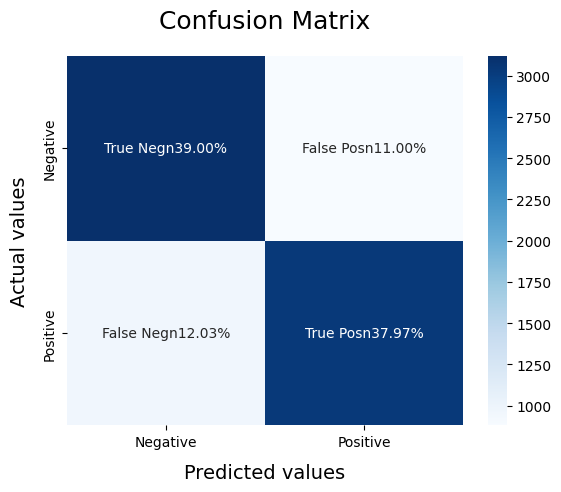

In [45]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_new, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test_new)

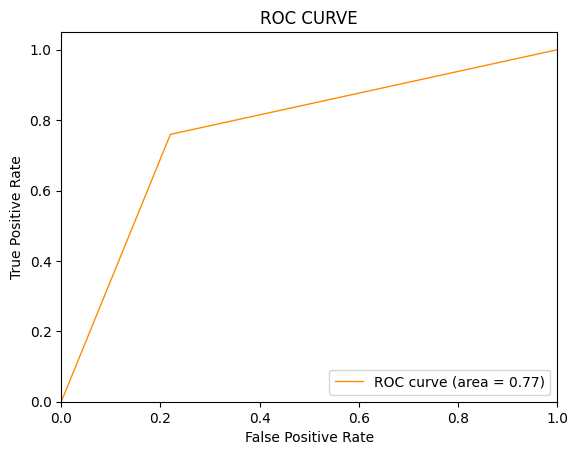

In [46]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()